We fit a t-copula to address the dependencies between assets, and then proceed to simulate stock return scenarios from this copula.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import t, norm
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf
import random
from scipy import optimize
import math

# Fit t-copula

Import the data

In [2]:
folderpath = "Data/Simulations/OPTIMIZATION 2005-2019"
pit = pd.read_csv(f"{folderpath}/PIT_SERIES.csv", index_col=0) # Log-returns from the in-sample period, transformed using the marginal t-distributions
logdiff = pd.read_csv(f"{folderpath}/Log_returns_empirical.csv", index_col=0) # Actual log-returns of the out-of-sample period
asset_stats = pd.read_csv(f"{folderpath}/COMPANY_SUMMARY.csv", index_col=0) # Statistics of individual companies
logdiff

,AGR.VI,ANDR.VI,CAI.VI,EBS.VI,EVN.VI,FLU.VI,IIA.VI,LNZ.VI,OMV.VI,PAL.VI,...,WRB,WTI,WTRG,WYNN,X,^GSPC,^FCHI,^GDAXI,^FTSE,^SSMI
2005-2,-0.026570,0.090018,0.005415,0.083487,0.115495,0.060571,0.001407,0.039806,0.090771,0.052512,...,0.061358,0.076729,0.015366,0.075141,0.174480,0.006157,0.028581,0.022229,0.029168,0.034970
2005-3,-0.051392,0.040455,-0.001474,-0.020847,-0.053382,-0.124856,-0.011316,0.007291,-0.065150,-0.032040,...,-0.014280,0.061408,0.010109,-0.035899,-0.184944,-0.000203,0.010036,-0.000395,-0.011243,-0.008105
2005-4,-0.046551,-0.114502,0.005394,-0.073517,-0.032109,0.011420,0.009940,-0.067610,-0.025203,-0.037041,...,-0.010244,-0.026818,0.098763,-0.239476,-0.166235,-0.013271,-0.039123,-0.038425,-0.002067,-0.002278
2005-5,0.004823,0.164660,-0.002370,0.077642,0.075574,0.033398,0.038894,-0.005195,0.193329,0.128801,...,0.132280,0.117725,0.069429,-0.077094,-0.024725,0.074627,0.052056,0.063822,0.029394,0.044959
2005-6,0.029125,0.106842,0.002450,0.034427,0.062100,0.029152,0.030854,0.002992,0.233587,0.153542,...,0.025379,0.127912,0.106327,0.026711,-0.128143,0.017643,0.026018,0.027779,0.032572,0.010035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-8,-0.081580,-0.009938,0.012500,-0.102829,0.064625,-0.071227,0.050993,-0.071982,0.023987,-0.034786,...,0.035096,-0.016161,0.068350,-0.147955,-0.292876,-0.009614,-0.006986,-0.020703,-0.040457,0.010474
2019-9,0.057089,0.157356,0.010811,0.035904,0.050837,0.029103,0.004118,0.029870,0.059191,0.066334,...,0.026026,0.008551,0.022956,-0.002230,0.053284,0.027872,0.035369,0.040125,0.046968,0.023782
2019-10,0.019872,0.071514,0.061076,0.042903,0.014760,-0.041257,0.007797,0.065705,0.060672,0.058308,...,-0.051958,-0.100165,-0.008077,0.090652,-0.022637,0.001058,0.009129,0.034691,0.007402,-0.003092
2019-11,0.058444,-0.129143,0.073798,0.025870,0.006086,0.021506,-0.047723,-0.066271,-0.011148,0.093177,...,-0.002268,0.073065,-0.005402,0.017148,0.147429,0.046358,0.030137,0.028320,0.027048,0.029717


Define the likelihood function

In [3]:
# A function to create the k-order approximation of a matrix based on the eigendecomposition. May have applications to ease the computation around the correlation matrix, but is not used.
def eigendecomposition_approximation(matrix, k):
    eig_val = np.diag(np.real(np.linalg.eig(matrix).eigenvalues[0:k]))
    eig_vec = np.real(np.linalg.eig(matrix).eigenvectors[:,0:k])
    return np.matmul(np.matmul(eig_vec,eig_val),eig_vec.transpose())

# nu = degrees of freedom
# pit = array of uniformly distributed observations
def likelihood(nu, pit):
    tmax = len(pit)
    n = len(pit.transpose())
    quantile_transform = stats.t.ppf(pit, df=nu)
    corr = np.corrcoef(quantile_transform.transpose())
    sum = 0
    for t in range(tmax):
        sum += stats.multivariate_t.logpdf(quantile_transform[t],shape=corr,df=nu)
        for i in range(n):
            sum -= stats.t.logpdf(quantile_transform[t,i],df=nu)
    return sum

#### Find the maximum likelihood estimator $\hat{\nu}$

In [4]:
# Likelihoods when using data from 2005-01 until 2019-12 (725 companies + 4 indices)
likelihoods = {8: 76539.63424183712, 9: 76760.49229640099, 10: 76867.3592108281, 11: 76903.70836917426, 12: 76894.34502628152, 13: 76854.23182087706}

# likelihoods = {}

In [ ]:
for i in [8,9,10,11,12,13]:
    likelihoods[i] = likelihood(i, pit)
    print(likelihoods)

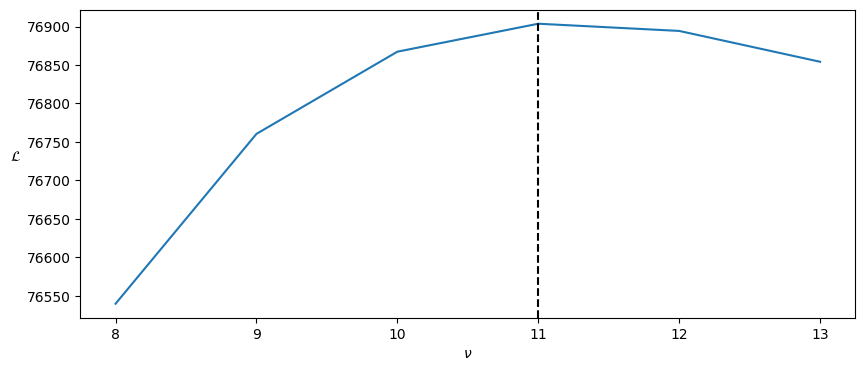

In [21]:
plt.figure(figsize=(10,4))
plt.plot(likelihoods.keys(),likelihoods.values())
plt.axvline(11, color='black', ls='--')
plt.xlabel(r"$\nu$"); plt.ylabel(r"$\mathcal{L}$", rotation='horizontal', horizontalalignment='right')
plt.savefig("Pictures/log_likelihood.png", dpi=300, bbox_inches='tight')
plt.show()

$\hat{\nu}=11$ is selected as the dof estimator

#### Building of the copula

In [5]:
nu = 11
quantile_transform = pd.DataFrame(t.ppf(pit, df=nu))
quantile_transform

,0,1,2,3,4,5,6,7,8,9,...,719,720,721,722,723,724,725,726,727,728
0,-0.529945,1.019085,-0.058524,0.888682,1.958908,0.944615,-0.100213,0.436270,1.121584,0.509354,...,1.025058,0.540538,0.076557,0.587124,1.217436,-0.080816,0.573351,0.295806,0.734953,0.916425
1,-0.976361,0.336640,-0.199032,-0.475221,-1.166753,-2.084363,-0.311976,0.026433,-0.976123,-0.460947,...,-0.562468,0.439301,-0.025292,-0.446853,-1.254492,-0.272127,0.139287,-0.255899,-0.473933,-0.501483
2,-0.890628,-1.731978,-0.058951,-1.094500,-0.771771,0.007569,0.044465,-0.905535,-0.442697,-0.517403,...,-0.477805,-0.148429,1.571105,-2.065283,-1.133454,-0.661763,-1.013173,-1.143929,-0.198999,-0.309447
3,0.050383,1.907919,-0.217129,0.821182,1.357339,0.446597,0.516056,-0.131599,2.350665,1.317850,...,2.294102,0.808958,1.084040,-0.818401,-0.159458,1.885847,1.126158,1.257562,0.741475,1.236868
4,0.499461,1.235224,-0.119223,0.273035,1.124535,0.363413,0.390904,-0.027991,2.781304,1.554067,...,0.280707,0.874986,1.688611,0.138652,-0.880442,0.264914,0.513272,0.429934,0.832864,0.097985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,-1.493116,-0.387880,0.086917,-1.379212,1.169381,-1.449996,0.692515,-0.957898,0.229534,-0.491984,...,0.486245,-0.077320,1.065191,-1.407994,-1.907915,-0.553390,-0.258610,-0.741218,-1.299474,0.112499
175,1.002348,1.828819,0.052278,0.292919,0.917851,0.362432,-0.054323,0.311641,0.706185,0.663737,...,0.294466,0.087640,0.223312,-0.133284,0.395213,0.570552,0.732715,0.723241,1.232266,0.551591
176,0.329268,0.771389,0.962558,0.386305,0.193762,-0.991610,0.008106,0.756455,0.725974,0.574425,...,-1.318538,-0.634483,-0.376042,0.726730,-0.144596,-0.234267,0.118085,0.595157,0.087383,-0.336320
177,1.026146,-1.892828,1.138862,0.156924,0.011358,0.211192,-0.844328,-0.889432,-0.251327,0.954414,...,-0.309177,0.516365,-0.324816,0.048831,1.040759,1.109916,0.609858,0.442930,0.673367,0.745791


A visualization of random return series, transformed with the t-distribution with $\hat{\nu}$
Remember that the t-copula couples an n-dimensional multivariate t-distribution and n standard t-distributions.

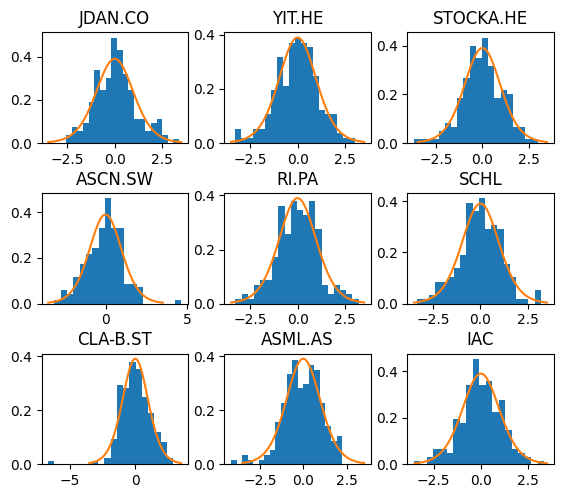

In [8]:
plot_count = 9
ncolumns = 3
seed = 2

fig, ax = plt.subplots(math.ceil(plot_count / ncolumns), ncolumns)
axislist = ax.flatten()
n = len(pit.transpose())
random.seed(seed)
x = np.linspace(-3.5,3.5,100)

for i in range(plot_count):
    ticker_index = random.randint(0,n)
    ticker = pit.columns[ticker_index]
    ax_i = axislist[i]
    ax_i.hist(quantile_transform.iloc[:,ticker_index],density=True, bins=20)
    ax_i.plot(x,t.pdf(x, df=nu))
    ax_i.set_title(ticker)

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=0.8,
                top=1,
                wspace=0.25,
                hspace=0.45)

plt.show()

Correlation and covariance matrices

In [6]:
corr = pd.DataFrame(np.corrcoef(quantile_transform.transpose()))
cov = pd.DataFrame(np.cov(quantile_transform.transpose()))
corr

,0,1,2,3,4,5,6,7,8,9,...,719,720,721,722,723,724,725,726,727,728
0,1.000000,0.350562,0.225510,0.283918,0.437252,0.197656,0.339253,0.285389,0.283576,0.373793,...,0.004050,0.143712,0.026775,0.144793,0.165175,0.285830,0.250476,0.227501,0.367418,0.239450
1,0.350562,1.000000,0.334752,0.372990,0.406213,0.368216,0.462313,0.428508,0.463626,0.403859,...,0.081443,0.300560,0.055043,0.264600,0.323156,0.484966,0.515893,0.525569,0.569310,0.435396
2,0.225510,0.334752,1.000000,0.466273,0.397879,0.412916,0.578435,0.448792,0.297288,0.431085,...,0.093208,0.219304,-0.124389,0.323280,0.317958,0.363052,0.551935,0.513008,0.481174,0.457545
3,0.283918,0.372990,0.466273,1.000000,0.311078,0.458417,0.487662,0.430483,0.379373,0.521059,...,0.001688,0.199757,-0.067970,0.356147,0.284761,0.402037,0.658718,0.616539,0.491692,0.482031
4,0.437252,0.406213,0.397879,0.311078,1.000000,0.322597,0.410372,0.260450,0.471199,0.373213,...,0.078534,0.293492,0.066138,0.205986,0.341811,0.285650,0.447269,0.381887,0.475215,0.367487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.285830,0.484966,0.363052,0.402037,0.285650,0.380233,0.401864,0.388825,0.393194,0.406534,...,0.498316,0.404364,0.421427,0.476623,0.451317,1.000000,0.682321,0.678878,0.763738,0.702217
725,0.250476,0.515893,0.551935,0.658718,0.447269,0.444515,0.542056,0.446356,0.542062,0.548287,...,0.185801,0.419108,0.058530,0.479472,0.438040,0.682321,1.000000,0.910243,0.780615,0.726508
726,0.227501,0.525569,0.513008,0.616539,0.381887,0.444356,0.497525,0.464470,0.478014,0.542940,...,0.195461,0.432809,0.021164,0.518896,0.456084,0.678878,0.910243,1.000000,0.732242,0.698551
727,0.367418,0.569310,0.481174,0.491692,0.475215,0.459963,0.465749,0.416174,0.559504,0.469821,...,0.219348,0.492756,0.201648,0.420053,0.422256,0.763738,0.780615,0.732242,1.000000,0.720925


Note that the order of the matrix is k=m-1, where m is the minimum of number of rows and number of columns
Floating point error causes a lot of the zeros to appear negative/imaginary
The k:th order approximation of the correlation matrix can be defined from the eigendecomposition

In [7]:
k = 178 # order of the approximation

new_corr = eigendecomposition_approximation(corr,k)
new_corr

array([[1.        , 0.35056221, 0.22551009, ..., 0.22750069, 0.36741768,
        0.23944974],
       [0.35056221, 1.        , 0.33475248, ..., 0.52556922, 0.56930981,
        0.43539556],
       [0.22551009, 0.33475248, 1.        , ..., 0.51300817, 0.48117421,
        0.45754488],
       ...,
       [0.22750069, 0.52556922, 0.51300817, ..., 1.        , 0.73224228,
        0.69855142],
       [0.36741768, 0.56930981, 0.48117421, ..., 0.73224228, 1.        ,
        0.72092509],
       [0.23944974, 0.43539556, 0.45754488, ..., 0.69855142, 0.72092509,
        1.        ]])

## Correlation matrix by industry

In [8]:
summary = pd.read_csv(f"{folderpath}/COMPANY_SUMMARY_2.csv", index_col=0)
summary["index"] = range(len(summary))
index_sorted_by_industry = summary.sort_values("Industry")[["Industry","index"]]
index_sorted_by_industry2 = summary.sort_values("Industry")["index"]
index_sorted_by_industry

,Industry,index
COA.L,Apparel,454
CRI.PA,Apparel,121
YPSN.SW,"Biotech, health care & pharma",434
ABT,"Biotech, health care & pharma",538
ACAD,"Biotech, health care & pharma",539
...,...,...
^GSPC,NaN,724
^FCHI,NaN,725
^GDAXI,NaN,726
^FTSE,NaN,727


In [9]:
industry = "Biotech, health care & pharma"
first_last_index = {"Apparel":(454,121),"Biotech, health care & pharma":(434,150), "Food, beverage & agriculture":(411,457), "Fossil Fuels":(176,525), "Hospitality":(275,535), "Infrastructure":(449,6), "Manufacturing":(60,185), "Materials":(7,346), "Power generation":(128,233), "Retail":(467,316), "Services":(235,478), "Transportation services":(71,637)}

In [10]:
corr_by_industry = corr.loc[index_sorted_by_industry2, index_sorted_by_industry2]
# corr_by_industry.to_csv(f"{folderpath}/correlation_sorted.csv", sep=";")

def correlation_range_by_industries(industry1, industry2):
    corr_of_industries = corr_by_industry.loc[first_last_index[industry1][0]:first_last_index[industry1][1],first_last_index[industry2][0]:first_last_index[industry2][1]]
    # return round(corr_of_industries.min().min(), 3), round(corr_of_industries.max().max(), 3)
    return round(corr_of_industries.mean().mean(),3)

industry1, industry2 = "Apparel", "Hospitality"
print("Mean of correlation coefficients")
corr_table = pd.DataFrame(index = first_last_index.keys(), columns = first_last_index.keys())
i = 0
for industry1 in first_last_index:
    for industry2 in first_last_index:
        mean = correlation_range_by_industries(industry1, industry2)
        # print(f"{industry1}, {industry2}: {mean}")

        corr_table.loc[industry1, industry2] = mean
corr_table.to_csv(f"{folderpath}/mean_correlation_by_industry.csv", sep=";")
corr_table

Mean of correlation coefficients


,Apparel,"Biotech, health care & pharma","Food, beverage & agriculture",Fossil Fuels,Hospitality,Infrastructure,Manufacturing,Materials,Power generation,Retail,Services,Transportation services
Apparel,0.681,0.19,0.199,0.22,0.244,0.249,0.297,0.305,0.17,0.216,0.261,0.219
"Biotech, health care & pharma",0.19,0.187,0.163,0.145,0.184,0.187,0.21,0.203,0.149,0.169,0.187,0.168
"Food, beverage & agriculture",0.199,0.163,0.212,0.159,0.184,0.19,0.207,0.204,0.173,0.179,0.187,0.16
Fossil Fuels,0.22,0.145,0.159,0.36,0.161,0.183,0.226,0.231,0.171,0.168,0.194,0.19
Hospitality,0.244,0.184,0.184,0.161,0.281,0.219,0.259,0.253,0.141,0.221,0.228,0.207
Infrastructure,0.249,0.187,0.19,0.183,0.219,0.268,0.256,0.252,0.188,0.212,0.235,0.206
Manufacturing,0.297,0.21,0.207,0.226,0.259,0.256,0.328,0.312,0.168,0.243,0.27,0.257
Materials,0.305,0.203,0.204,0.231,0.253,0.252,0.312,0.323,0.171,0.234,0.265,0.25
Power generation,0.17,0.149,0.173,0.171,0.141,0.188,0.168,0.171,0.302,0.158,0.171,0.143
Retail,0.216,0.169,0.179,0.168,0.221,0.212,0.243,0.234,0.158,0.239,0.217,0.201


dict_keys(['Apparel', 'Biotech, health care & pharma', 'Food, beverage & agriculture', 'Fossil Fuels', 'Hospitality', 'Infrastructure', 'Manufacturing', 'Materials', 'Power generation', 'Retail', 'Services', 'Transportation services'])

# Sampling from the copula

We define functions for drawing scenarios from the t-copula, utilizing a multivariate t and univariate t-distributions.

In [26]:
J = 10000 # number of samples
T = 12 # optimization period (months)
# Note that the actual number of samples drawn from the copula is N = J * T

def draw_uniform_samples(nu, size, period):
    multidim_distribution = stats.multivariate_t(df=nu, shape=new_corr, allow_singular=True, seed=123)
    sample1 = multidim_distribution.rvs(size*period)
    return stats.t.cdf(sample1, df=nu)


def uniform_to_marginal(uniform_sample, marginal_df, marginal_loc, marginal_scale):
    marginal_sample = uniform_sample.copy()
    n = len(marginal_sample.transpose())
    assert n == len(marginal_df); assert n == len(marginal_loc); assert n == len(marginal_scale)
    for i in range(n):
        marginal_sample[:,i] = stats.t.ppf(marginal_sample[:,i], df=marginal_df[i], loc=marginal_loc[i], scale=marginal_scale[i])
    return pd.DataFrame(marginal_sample)

# We drop log-return scenarios outside [-4, 4] to obtain more robust results
def drop_outliers(sample, threshold_min, threshold_max):
    over_max_indices = np.where(sample.max(axis=1) > threshold_max)[0]
    below_min_indices = np.where(sample.min(axis=1) < threshold_min)[0]
    drop_indices = np.unique(np.concatenate([over_max_indices, below_min_indices]))
    return sample.drop(labels=drop_indices)

# To aggregate 1-period returns to longer periods (we aggregate the 1-month-returns to 12-month return scenarios)
def to_periodic(marginal, period):
    # Cut down to be divisible by period
    new_length0 = len(marginal)//period
    new_length1 = new_length0 * period
    periodic = marginal.copy().iloc[:new_length1,]
    periodic["new_index"] = periodic.index % new_length0
    return periodic.groupby("new_index").sum()

In [5]:
#monthly_scenarios = uniform_to_marginal(draw_uniform_samples(nu,J,T), asset_stats["DoF"], asset_stats["Location"], asset_stats["Scale"])
#monthly_scenarios = drop_outliers(monthly_scenarios, -4, 4)
#monthly_scenarios.to_csv(f"{folderpath}/Simulation_monthly.csv")
monthly_scenarios = pd.read_csv(f"{folderpath}/Simulation_monthly.csv", index_col=0)
monthly_scenarios

,0,1,2,3,4,5,6,7,8,9,...,719,720,721,722,723,724,725,726,727,728
0,-0.011800,0.052486,-0.017730,0.009877,-0.037083,-0.053314,-0.010041,0.003099,0.029369,0.025356,...,-0.031492,0.048752,-0.058895,-0.042623,-0.051432,-0.000027,-0.025171,-0.015434,-0.006245,0.038087
1,-0.034490,-0.001221,0.011080,0.019806,0.004622,0.004686,-0.006611,0.033401,0.000309,0.016512,...,0.092469,0.019982,0.028833,0.012384,-0.049568,0.020628,0.000412,0.022267,0.013569,0.005216
2,-0.038762,0.133344,0.049327,0.015802,0.041963,-0.080240,-0.035534,0.008916,0.025007,0.014119,...,0.035504,-0.270087,0.052760,-0.145777,-0.020910,0.030806,0.093940,0.103836,0.052661,0.076486
3,-0.003818,-0.075264,0.036177,0.023610,0.025775,0.073049,0.004397,0.008627,0.057361,0.005069,...,-0.028873,0.257697,-0.034747,-0.011324,-0.063167,-0.017992,-0.001637,0.014123,0.015174,0.016949
4,-0.049131,0.025942,0.386533,-0.063835,0.183638,-0.063688,0.025637,0.011628,-0.028935,-0.004287,...,0.013621,-0.253146,0.074071,-0.101348,0.297698,-0.064772,-0.051424,-0.069869,-0.043905,0.014883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,-0.097492,0.072409,0.014973,0.000478,-0.071434,-0.022135,-0.045475,0.028381,-0.067512,0.005520,...,0.075586,-0.301762,0.014681,-0.149465,-0.231593,0.027648,-0.001188,0.010946,-0.025052,0.004111
119996,0.015012,-0.008121,0.002963,0.007989,-0.048595,0.042889,-0.159735,0.074754,-0.039789,-0.043808,...,0.132152,-0.174803,0.084266,-0.083404,-0.066727,0.028655,-0.021657,-0.005719,0.022004,0.051287
119997,-0.084229,-0.112197,-0.060382,-0.005021,-0.028899,0.022087,0.029132,-0.069713,-0.090532,0.001106,...,-0.039412,-0.032219,0.009186,-0.029636,-0.183553,0.005531,-0.004897,-0.022335,0.010996,-0.019941
119998,0.081495,0.112484,0.222126,0.467314,0.134702,0.337390,0.198386,0.520803,0.178775,0.079705,...,0.039919,-0.040982,0.076686,0.076672,0.020578,0.038461,0.106957,0.042967,0.073870,0.060030


NOTE: $\nu\in(1,2]$ has infinite variance
Samples outside [-4,4] have been left out. The extreme values in all data:

In [6]:
print("Simulation (max/min):")
print(monthly_scenarios.max().max())
print(monthly_scenarios.min().min())
print("Real data (max/min):")
print(logdiff.max().max())
print(logdiff.min().min())

Simulation (max/min):
3.9944775017120016
-3.977487235541837
Real data (max/min):
3.703422369326077
-3.5886319589508187


In [7]:
#yearly_scenarios = to_periodic(monthly_scenarios, T)
#yearly_scenarios.to_csv(f"{folderpath}/Simulation_yearly.csv")
yearly_scenarios = pd.read_csv(f"{folderpath}/Simulation_yearly.csv", index_col=0)
yearly_scenarios

,0,1,2,3,4,5,6,7,8,9,...,719,720,721,722,723,724,725,726,727,728
new_index,,,,,,,,,,,,,,,,,,,,,
0,-0.361641,0.025300,-0.017884,-0.328816,0.102562,0.239235,0.290527,0.013133,0.061670,0.018328,...,0.414030,0.226330,0.072035,-0.020670,-0.323423,0.039576,-0.130203,-0.111460,0.004324,0.004968
1,-0.080619,0.200035,0.410595,0.642575,-0.079059,0.373220,0.457856,0.130307,-0.127835,0.382702,...,0.204518,0.440054,0.230584,0.612936,-0.885648,0.214308,0.279716,0.379269,0.122833,0.138804
2,0.022413,0.785800,0.243070,0.501552,0.269242,0.098371,0.059303,0.215718,0.431704,-0.167935,...,0.325220,-1.318037,0.226115,-0.097301,-0.359928,0.084420,0.169046,0.203078,0.054307,0.214285
3,0.018264,-0.164553,0.135492,1.012201,0.024176,-0.001702,-0.109404,0.184594,-0.318944,0.423081,...,-0.109172,-1.124376,-0.379577,0.145495,-0.115369,-0.073069,-0.091061,0.033755,-0.148585,-0.069130
4,0.180607,0.515797,0.823579,0.444868,0.489654,0.174025,0.080160,0.453612,0.254266,0.493629,...,0.063276,0.038117,-0.219265,0.086313,0.845619,0.136695,0.264489,0.257219,0.151327,0.163004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9937,-0.355459,0.124163,-0.336629,0.442871,-0.035644,0.035381,-0.532625,0.066850,0.166207,0.208170,...,0.091393,0.013969,-0.193308,0.196832,0.384364,0.165241,0.194696,0.359743,0.150914,0.185158
9938,-0.051967,0.102185,-0.054978,0.168930,-0.085688,0.320949,-0.413690,0.157472,-0.517930,-0.071954,...,-0.028330,0.256964,0.289644,-0.006873,0.251210,0.163164,0.017900,0.111687,0.209871,0.097158
9939,0.059176,0.148189,0.228922,0.274445,0.214261,0.541271,-0.158352,0.133555,-0.476682,0.487834,...,0.113983,-0.232247,0.105790,0.306145,0.876101,0.104633,0.097721,0.199502,0.005758,0.195861


# Visual inspection of the simulation

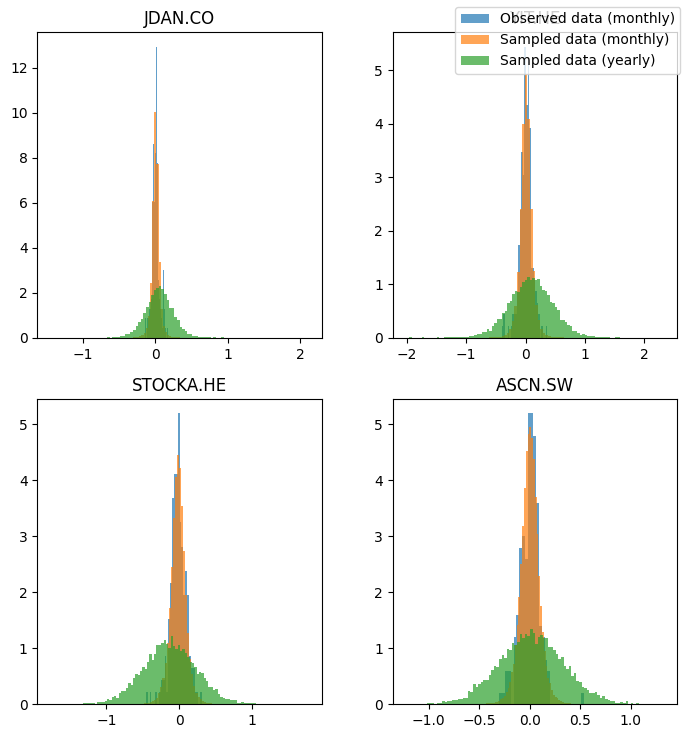

In [9]:
plot_count = 4
ncolumns = 2
seed = 2

fig, ax = plt.subplots(math.ceil(plot_count / ncolumns), ncolumns)
axislist = ax.flatten()
n = len(pit.transpose())
random.seed(seed)

for i in range(plot_count):
    ticker_index = random.randint(0,n)
    ticker = pit.columns[ticker_index]
    ax_i = axislist[i]
    ax_i.hist(logdiff.iloc[:, ticker_index], density=True, bins=30, alpha=0.7)
    ax_i.hist(monthly_scenarios.iloc[:, ticker_index], density=True, bins=100, alpha=0.7)
    ax_i.hist(yearly_scenarios.iloc[:, ticker_index], density=True, bins=100, alpha=0.7)
    ax_i.set_title(ticker)

fig.legend(["Observed data (monthly)", "Sampled data (monthly)", "Sampled data (yearly)"])

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=1,
                top=1.5,
                wspace=0.25,
                hspace=0.2)
plt.show()

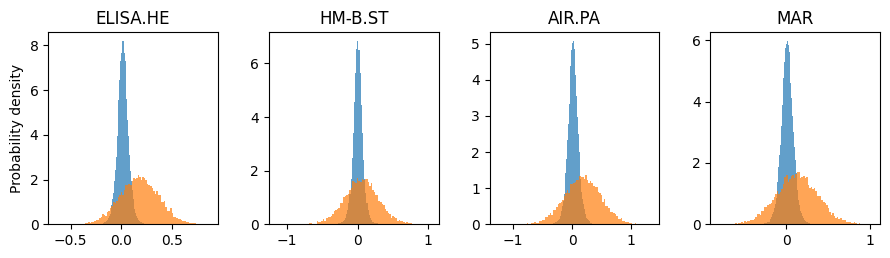

In [40]:
# Visual inspection of individual companies
tickers = ["ELISA.HE", "HM-B.ST", "AIR.PA", "MAR"]

fig, ax = plt.subplots(1, len(tickers))
axislist = ax.flatten()

for i in range(len(tickers)):
    ticker = tickers[i]
    ticker_index = list(logdiff.columns).index(ticker)
    ax_i = axislist[i]
    #ax_i.hist(logdiff.iloc[:, ticker_index], density=True, bins=30, alpha=0.7)
    ax_i.hist(monthly_scenarios.iloc[:, ticker_index], density=True, bins=100, alpha=0.7)
    ax_i.hist(yearly_scenarios.iloc[:, ticker_index], density=True, bins=100, alpha=0.7)
    ax_i.set_title(ticker)

axislist[0].set_ylabel("Probability density")
plt.subplots_adjust(left=0,
                    bottom=0.1,
                    right=1.3,
                    top=0.5,
                    wspace=0.3,
                    hspace=0.2)
#fig.legend(["Realized 1-month returns", "Simulated 1-month returns", "Simulated 12-month returns"], loc=(0.063,0.71), prop={'size':11}, ncol=3)
plt.savefig("Pictures/scenario_distributions.png", dpi=300, bbox_inches = 'tight')
plt.show()

### Exponentiate returns

In [33]:
#return_rate_yearly = np.exp(yearly_scenarios)
return_rate_yearly = pd.read_csv(f"{folderpath}/Simulation_exp_returns.csv", index_col=0)
#return_rate_yearly.to_csv(f"{folderpath}/Simulation_exp_returns.csv")
#return_rate_monthly = np.exp(monthly_scenarios)
return_rate_monthly = pd.read_csv(f"{folderpath}/Simulation_exp_returns_monthly.csv", index_col=0)
#return_rate_monthly.to_csv(f"{folderpath}/Simulation_exp_returns_monthly.csv")
return_rate_yearly

,0,1,2,3,4,5,6,7,8,9,...,719,720,721,722,723,724,725,726,727,728
new_index,,,,,,,,,,,,,,,,,,,,,
0,0.696532,1.025622,0.982275,0.719775,1.108006,1.270277,1.337133,1.013219,1.063612,1.018497,...,1.512902,1.253989,1.074693,0.979542,0.723668,1.040370,0.877917,0.894527,1.004333,1.004980
1,0.922545,1.221445,1.507715,1.901371,0.923985,1.452404,1.580681,1.139178,0.879998,1.466240,...,1.226933,1.552791,1.259335,1.845842,0.412447,1.239004,1.322753,1.461216,1.130695,1.148899
2,1.022666,2.194162,1.275159,1.651282,1.308972,1.103372,1.061096,1.240752,1.539880,0.845409,...,1.384335,0.267660,1.253720,0.907283,0.697726,1.088086,1.184174,1.225168,1.055808,1.238976
3,1.018432,0.848273,1.145100,2.751649,1.024470,0.998300,0.896368,1.202730,0.726916,1.526658,...,0.896576,0.324855,0.684151,1.156612,0.891037,0.929537,0.912962,1.034332,0.861927,0.933205
4,1.197944,1.674973,2.278640,1.560284,1.631752,1.190085,1.083460,1.573987,1.289515,1.638251,...,1.065321,1.038853,0.803109,1.090147,2.329419,1.146479,1.302765,1.293328,1.163376,1.177041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9937,0.700852,1.132200,0.714173,1.557171,0.964984,1.036014,0.587062,1.069135,1.180818,1.231423,...,1.095700,1.014067,0.824228,1.217539,1.468680,1.179677,1.214941,1.432961,1.162897,1.203408
9938,0.949360,1.107588,0.946506,1.184037,0.917880,1.378435,0.661206,1.170548,0.595753,0.930574,...,0.972068,1.292999,1.335952,0.993151,1.285580,1.177230,1.018061,1.118162,1.233519,1.102035
9939,1.060961,1.159732,1.257244,1.315800,1.238946,1.718190,0.853549,1.142884,0.620840,1.628784,...,1.120734,0.792751,1.111588,1.358180,2.401518,1.110303,1.102655,1.220795,1.005774,1.216358


In [56]:
exp_of_mean = np.exp(yearly_scenarios.mean())
mean_of_exp = return_rate_yearly.mean()
monthly_exp = return_rate_monthly.mean()
return_stats = pd.DataFrame(columns=["Monthly RR (mean)", "Yearly RR (mean)", "Yearly RR (median)"], index=logdiff.columns)
return_stats["Monthly RR (mean)"] = monthly_exp.to_numpy(); return_stats["Yearly RR (mean)"] = mean_of_exp.to_numpy(); return_stats["Yearly RR (median)"] = exp_of_mean.to_numpy()
return_stats["Difference of mean and median"] = return_stats["Yearly RR (mean)"] - return_stats["Yearly RR (median)"]
exp_df_sorted = return_stats.sort_values("Yearly RR (mean)")
return_stats["Simulated min (monthly)"] = monthly_scenarios.min().to_numpy(); return_stats["Simulated max (monthly)"] = monthly_scenarios.max().to_numpy()
return_stats["Data min (monthly)"] = logdiff.min().to_numpy(); return_stats["Data max (monthly)"] = logdiff.max().to_numpy()

return_stats

,Monthly RR (mean),Yearly RR (mean),Yearly RR (median),Difference of mean and median,Simulated min (monthly),Simulated max (monthly),Data min (monthly),Data max (monthly)
AGR.VI,1.004070,1.050299,1.024996,0.025303,-0.615822,0.496486,-0.185977,0.253823
ANDR.VI,1.021202,1.286276,1.228873,0.057403,-0.949877,1.174923,-0.498934,0.254428
CAI.VI,1.016047,1.213383,1.101730,0.111653,-3.927275,3.632792,-0.356965,0.511930
EBS.VI,1.021983,1.293322,1.187966,0.105357,-3.201627,2.634040,-0.507445,0.508215
EVN.VI,1.007575,1.094351,1.068034,0.026317,-1.030443,0.950417,-0.260698,0.211472
...,...,...,...,...,...,...,...,...
^GSPC,1.009644,1.121861,1.112174,0.009687,-0.333226,0.282232,-0.113842,0.103280
^FCHI,1.005103,1.062522,1.049624,0.012897,-0.233927,0.231474,-0.145225,0.118287
^GDAXI,1.011288,1.143714,1.127417,0.016297,-0.418190,0.408225,-0.213096,0.154968
^FTSE,1.005306,1.065421,1.055310,0.010110,-0.353391,0.318220,-0.145184,0.109143


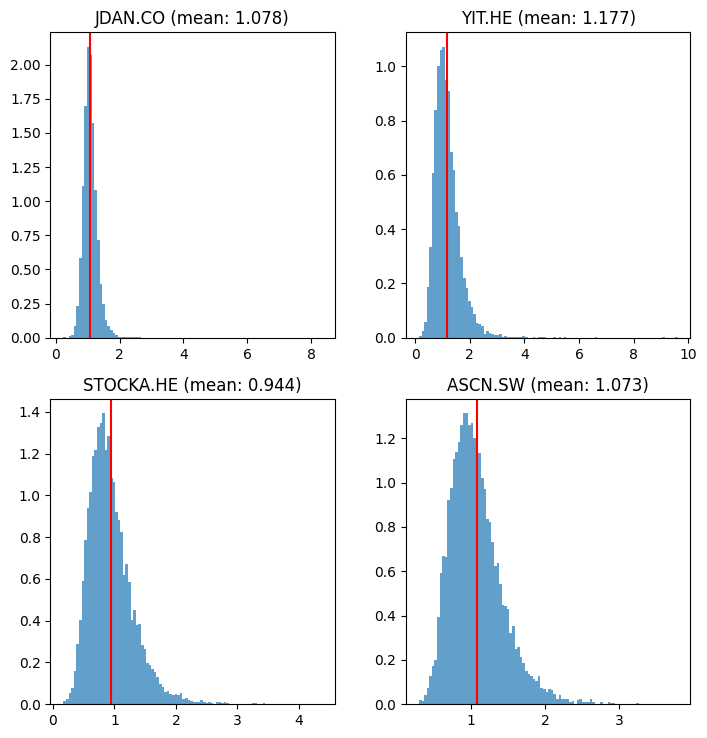

In [57]:
plot_count = 4
ncolumns = 2
seed = 2

fig, ax = plt.subplots(math.ceil(plot_count / ncolumns), ncolumns)
axislist = ax.flatten()
n = len(pit.transpose())
random.seed(seed)

for i in range(plot_count):
    ticker_index = random.randint(0,n)
    ticker = pit.columns[ticker_index]
    ax_i = axislist[i]
    ax_i.hist(return_rate_yearly.iloc[:, ticker_index], density=True, bins=100, alpha=0.7)
    expected_profit_rate = mean_of_exp[ticker_index]
    ax_i.axvline(expected_profit_rate, color='red')
    ax_i.set_title(f"{ticker} (mean: {round(expected_profit_rate,3)})")

plt.subplots_adjust(left=0,
                bottom=0.1,
                right=1,
                top=1.5,
                wspace=0.25,
                hspace=0.2)
plt.show()

The red line describes the expectation (will be used in the loss function approximation)

In [58]:
trimmed_mean = (return_rate_yearly.sum() - return_rate_yearly.min() - return_rate_yearly.max()) / (return_rate_yearly.count() - 2)

In [59]:
# Calculate CVaR of individual assets

def empirical_cvar(return_rate_data, alpha):
    sorted_return_rate = return_rate_data.copy() - 1
    for i in sorted_return_rate:
        sorted_return_rate[i] = np.sort(sorted_return_rate[i])
    cvar_individual = -sorted_return_rate[:int(len(sorted_return_rate)*(1-alpha))].mean()
    return cvar_individual.to_numpy()

return_stats["Simulated 0.90-CVaR (monthly)"] = empirical_cvar(return_rate_monthly, 0.9)
return_stats["Simulated 0.90-CVaR (yearly)"] = empirical_cvar(return_rate_yearly, 0.9)
return_stats["Empirical 0.90-CVaR (monthly)"] = empirical_cvar(np.exp(logdiff), 0.9)
return_stats["Empirical 0.95-CVaR (monthly)"] = empirical_cvar(np.exp(logdiff), 0.95)

return_stats

,Monthly RR (mean),Yearly RR (mean),Yearly RR (median),Difference of mean and median,Simulated min (monthly),Simulated max (monthly),Data min (monthly),Data max (monthly),Simulated 0.90-CVaR (monthly),Simulated 0.90-CVaR (yearly),Empirical 0.90-CVaR (monthly),Empirical 0.95-CVaR (monthly)
AGR.VI,1.004070,1.050299,1.024996,0.025303,-0.615822,0.496486,-0.185977,0.253823,0.104540,0.301417,0.105519,0.129969
ANDR.VI,1.021202,1.286276,1.228873,0.057403,-0.949877,1.174923,-0.498934,0.254428,0.126969,0.270511,0.149753,0.204821
CAI.VI,1.016047,1.213383,1.101730,0.111653,-3.927275,3.632792,-0.356965,0.511930,0.149836,0.439483,0.165850,0.220536
EBS.VI,1.021983,1.293322,1.187966,0.105357,-3.201627,2.634040,-0.507445,0.508215,0.168732,0.413232,0.213051,0.267602
EVN.VI,1.007575,1.094351,1.068034,0.026317,-1.030443,0.950417,-0.260698,0.211472,0.101617,0.270039,0.109880,0.135954
...,...,...,...,...,...,...,...,...,...,...,...,...
^GSPC,1.009644,1.121861,1.112174,0.009687,-0.333226,0.282232,-0.113842,0.103280,0.057889,0.117535,0.071446,0.090267
^FCHI,1.005103,1.062522,1.049624,0.012897,-0.233927,0.231474,-0.145225,0.118287,0.074273,0.202063,0.087423,0.107411
^GDAXI,1.011288,1.143714,1.127417,0.016297,-0.418190,0.408225,-0.213096,0.154968,0.075279,0.160775,0.091951,0.122470
^FTSE,1.005306,1.065421,1.055310,0.010110,-0.353391,0.318220,-0.145184,0.109143,0.064843,0.172366,0.078659,0.099650


Mean vs median of exp returns, to highlight that $\mathbb{E}[e^{X}]\neq e^{\mathbb{E}[X]}$
If the mean is significantly higher than the median, the asset most probably has very high volatility

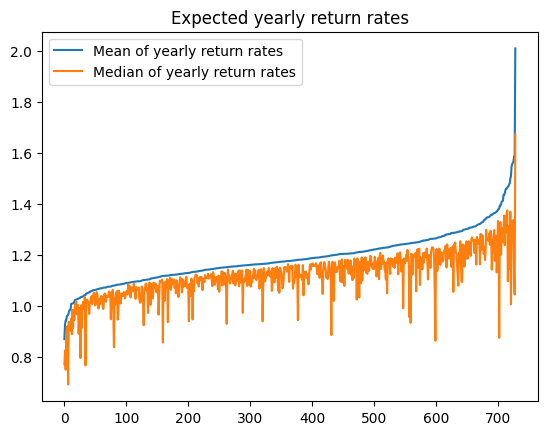

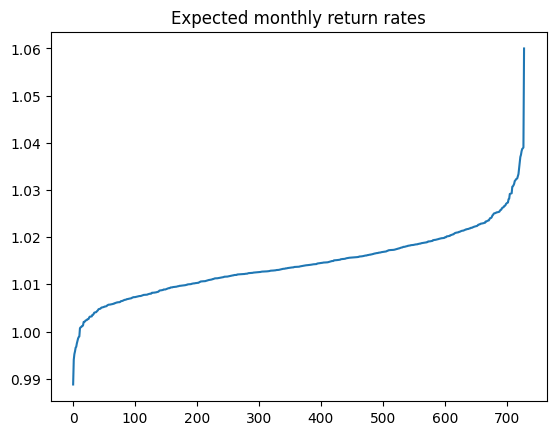

In [60]:
n = len(yearly_scenarios.transpose())
#plt.scatter(exp_df[0],exp_df[1])
plt.plot(range(n), exp_df_sorted["Yearly RR (mean)"])
plt.plot(range(n), exp_df_sorted["Yearly RR (median)"])
plt.legend(("Mean of yearly return rates", "Median of yearly return rates"))
plt.title("Expected yearly return rates")
plt.show()
plt.plot(range(n), np.sort(monthly_exp))
plt.title("Expected monthly return rates")
plt.show()

# Construct the summary table

Statistical summary of each individual company.

In [61]:
financed_emissions = pd.read_csv(f"{folderpath}/Emission_data.csv", index_col=0)
summary = pd.concat((financed_emissions, asset_stats, return_stats),axis=1)
summary.to_csv(f"{folderpath}/COMPANY_SUMMARY_2.csv")
summary

,Country,Company Name,CDP Score,Industry,CE (tCO2e),Estimated EVIC (MEUR),Emission intensity (tCO2e/MEUR),KS p-value,DoF,Location,...,Yearly RR (median),Difference of mean and median,Simulated min (monthly),Simulated max (monthly),Data min (monthly),Data max (monthly),Simulated 0.90-CVaR (monthly),Simulated 0.90-CVaR (yearly),Empirical 0.90-CVaR (monthly),Empirical 0.95-CVaR (monthly)
AGR.VI,Austria,AGRANA Beteiligungs-AG,3.0,"Food, beverage & agriculture",381000.0,2035.221761,187.203187,0.995929,6.128094,0.002111,...,1.024996,0.025303,-0.615822,0.496486,-0.185977,0.253823,0.104540,0.301417,0.105519,0.129969
ANDR.VI,Austria,ANDRITZ AG,4.5,Manufacturing,222452.0,3354.578799,66.312945,0.979662,4.706482,0.017056,...,1.228873,0.057403,-0.949877,1.174923,-0.498934,0.254428,0.126969,0.270511,0.149753,0.204821
CAI.VI,Austria,CA Immobilien Anlagen AG,7.0,Infrastructure,50945.0,4327.273630,11.773002,0.938119,1.924503,0.008265,...,1.101730,0.111653,-3.927275,3.632792,-0.356965,0.511930,0.149836,0.439483,0.165850,0.220536
EBS.VI,Austria,Erste Group Bank AG,5.5,Services,71950.0,63710.792646,1.129322,0.913163,2.632979,0.014417,...,1.187966,0.105357,-3.201627,2.634040,-0.507445,0.508215,0.168732,0.413232,0.213051,0.267602
EVN.VI,Austria,EVN AG,5.0,Infrastructure,3050754.0,6717.123518,454.175659,0.993103,3.830549,0.005547,...,1.068034,0.026317,-1.030443,0.950417,-0.260698,0.211472,0.101617,0.270039,0.109880,0.135954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
^GSPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996100,6.721482,0.008840,...,1.112174,0.009687,-0.333226,0.282232,-0.113842,0.103280,0.057889,0.117535,0.071446,0.090267
^FCHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978777,12.957709,0.004077,...,1.049624,0.012897,-0.233927,0.231474,-0.145225,0.118287,0.074273,0.202063,0.087423,0.107411
^GDAXI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921631,5.094028,0.010095,...,1.127417,0.016297,-0.418190,0.408225,-0.213096,0.154968,0.075279,0.160775,0.091951,0.122470
^FTSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.889567,5.067769,0.004515,...,1.055310,0.010110,-0.353391,0.318220,-0.145184,0.109143,0.064843,0.172366,0.078659,0.099650
